In [22]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn import metrics

In [23]:
cd "G:\My Drive\GRAD-C24_Machine_Learning\data"

G:\My Drive\GRAD-C24_Machine_Learning\data


In [39]:
# Negative Sample
neg_sample_visibility = pd.read_csv('../data/processed/neg_sample_visibility.csv', index_col=[0])
neg_sample_temperature = pd.read_csv('../data/processed/neg_sample_temperature.csv', index_col=[0])
neg_sample_precipitation = pd.read_csv('../data/processed/neg_sample_precipitation.csv', index_col=[0])
negative_sample = pd.read_csv('../data/processed/negative_sample.csv', index_col=[0])

# Positive sample
pos_sample_visibility = pd.read_csv('../data/processed/pos_sample_visibility.csv', index_col=[0])
pos_sample_temperature = pd.read_csv('../data/processed/pos_sample_temperature.csv', index_col=[0])
pos_sample_precipitation = pd.read_csv('../data/processed/pos_sample_precipitation.csv', index_col=[0])
positive_sample = pd.read_csv('../data/processed/positive_sample.csv', index_col=[0])
pos_sample_precipitation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52118 entries, 0 to 107727
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           52118 non-null  int64  
 1   month          52118 non-null  int64  
 2   weekday        52118 non-null  int64  
 3   hour           52118 non-null  int64  
 4   segment_id     52118 non-null  float64
 5   prec_duration  52118 non-null  float64
 6   prec_height    52118 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 3.2 MB


In [40]:
# Merge (we need to reset index of precipitation df)
negative_sample['humidity'], negative_sample['temparature'], negative_sample['visibility'],negative_sample['prec_height'],negative_sample['prec_duration']  =  neg_sample_temperature['humidity'], neg_sample_temperature['temperature'], neg_sample_visibility['visibility'],neg_sample_precipitation.reset_index()['prec_height'],neg_sample_precipitation.reset_index()['prec_duration'] 
positive_sample['humidity'], positive_sample['temparature'], positive_sample['visibility'],positive_sample['prec_height'],positive_sample['prec_duration']  =  pos_sample_temperature['humidity'], pos_sample_temperature['temperature'], pos_sample_visibility['visibility'],pos_sample_precipitation.reset_index()['prec_height'],pos_sample_precipitation.reset_index()['prec_duration'] 

full_data = negative_sample.append(positive_sample)

C:\Users\admin\AppData\Local\Temp/ipykernel_68260/605013631.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = negative_sample.append(positive_sample)


In [41]:
# FUll DATA
full_data = full_data[[
    'segment_id',
    'year',
    'month_cos',
    'month_sin',
    'weekday',
    'hour_cos',
    'hour_sin',
    'collision_cnt',
    'side_strt',
    'length_m',
    'sun_elevation_angle',
    'humidity',
    'temparature',
    'visibility',
    'prec_height',
    'prec_duration',
    'collision'
]]

full_data['collision_cnt'] = full_data['collision_cnt'].fillna(0)

full_data = full_data.round(3)

#full_data['weekday'] = full_data['weekday'].astype('category')

In [42]:
full_data = full_data.round(3)

In [43]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312820 entries, 0 to 52117
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   segment_id           312820 non-null  float64
 1   year                 312820 non-null  int64  
 2   month_cos            312820 non-null  float64
 3   month_sin            312820 non-null  float64
 4   weekday              312820 non-null  int64  
 5   hour_cos             312820 non-null  float64
 6   hour_sin             312820 non-null  float64
 7   collision_cnt        312820 non-null  float64
 8   side_strt            312820 non-null  float64
 9   length_m             312820 non-null  float64
 10  sun_elevation_angle  312820 non-null  float64
 11  humidity             312820 non-null  float64
 12  temparature          312820 non-null  float64
 13  visibility           312820 non-null  float64
 14  prec_height          312820 non-null  float64
 15  prec_duration     

In [44]:
full_data[full_data.select_dtypes(np.float64).columns] = full_data.select_dtypes(np.float64).astype(np.float32)

In [46]:
full_data['length_m'].describe()

count    312820.000000
mean        164.144318
std         159.658264
min           3.551000
25%          82.663002
50%         127.566002
75%         201.384995
max        6402.402832
Name: length_m, dtype: float64

In [47]:
# Split
X_train = full_data[full_data['year'] < 2020].drop(['collision','segment_id'],axis=1)
X_test = full_data[full_data['year'] == 2020].drop(['collision','segment_id'],axis=1)

y_train = full_data[full_data['year'] < 2020]['collision']
y_test = full_data[full_data['year'] == 2020]['collision']

In [48]:
# Random Forest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import cross_validate

num_pipe = SimpleImputer(strategy="mean", add_indicator=True)
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor_tree = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

In [49]:
# Random Forest
rf_clf = make_pipeline(
    preprocessor_tree, RandomForestClassifier(n_estimators = 450,
                               min_samples_split = 2,
                               min_samples_leaf = 1,
                               max_features = 'log2',
                               max_depth = 30,
                               criterion = 'entropy',
                               bootstrap = False)
)

rf_clf.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=2,
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028A04EA8A00>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028A04EA8100>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=30, max_features='log2',
                              

In [50]:
rf_clf.fit(X_train, y_train).steps[1][1].feature_importances_

array([0.005172  , 0.0066247 , 0.00687238, 0.05779227, 0.02475429,
       0.02258277, 0.40423924, 0.05732422, 0.12995624, 0.14376731,
       0.04096053, 0.03534203, 0.01808269, 0.02189136, 0.02463797])

Text(0, 0.5, 'Mean decrease in impurity')

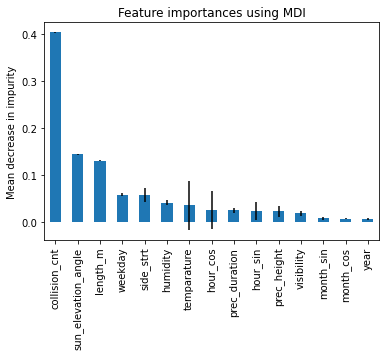

In [51]:
# Plot Feature Importance for baseline RF model

import time
import numpy as np

forest_importances = pd.Series(rf_clf.steps[1][1].feature_importances_, index=rf_clf.feature_names_in_)

start_time = time.time()
importances = rf_clf.steps[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.steps[1][1].estimators_], axis=0)
elapsed_time = time.time() - start_time

fig, ax = plt.subplots()
forest_importances.sort_values(axis=0, ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [ ]:
#fig.savefig("feature_importance_rf.png",bbox_inches='tight')

In [52]:
y_pred_rf = rf_clf.predict(X_test)

In [53]:
# Model Accuracy, how often is the classifier correct
print("ROC_AUC:",metrics.roc_auc_score(y_test, y_pred_rf))
print("Recall:",metrics.recall_score(y_test, y_pred_rf))
print("F1:",metrics.f1_score(y_test, y_pred_rf))
print("Precision:",metrics.precision_score(y_test, y_pred_rf))

ROC_AUC: 0.8404908653726955
Recall: 0.7193379900572651
F1: 0.7460757758705088
Precision: 0.7748779826464208


In [54]:
# Balanced Random Forest
brf_clf = BalancedRandomForestClassifier(n_estimators = 500,
                               min_samples_split = 2,
                               min_samples_leaf = 1,
                               max_features = 'log2',
                               max_depth = 30,
                               criterion = 'entropy',
                               bootstrap = False)
brf_clf.fit(X_train,y_train)

BalancedRandomForestClassifier(bootstrap=False, criterion='entropy',
                               max_depth=30, max_features='log2',
                               n_estimators=500)

In [55]:
y_pred_brf = brf_clf.predict(X_test)

In [56]:
# Model Accuracy, how often is the classifier correct
print("ROC_AUC:",metrics.roc_auc_score(y_test, y_pred_brf))
print("Recall:",metrics.recall_score(y_test, y_pred_brf))
print("F1:",metrics.f1_score(y_test, y_pred_brf))
print("Precision:",metrics.precision_score(y_test, y_pred_brf))

ROC_AUC: 0.8872700140030698
Recall: 0.9455666729595369
F1: 0.6572334609075998
Precision: 0.5036535496413488


In [39]:
#Random Forest with oversampling using SMOTE and undersampling using RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

# oversample positive (minority) to be x% the number of negative (majority)
over = SMOTE(sampling_strategy = 0.3)

# randomly undersample negative (majority) to reduce the number of negative to x% of the positive (minority)
under = RandomUnderSampler(sampling_strategy = 0.5) 

pipeline = make_pipeline(over, under)

X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)


rf_sampling_clf = RandomForestClassifier(n_estimators = 500,
                               min_samples_split = 2,
                               min_samples_leaf = 1,
                               max_features = 'sqrt',
                               max_depth = 30,
                               criterion = 'entropy',
                               bootstrap = False)

In [40]:
rf_sampling_clf.fit(X_train_res,y_train_res)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=30,
                       max_features='sqrt', n_estimators=500)

In [41]:
y_pred_rf_s = rf_sampling_clf.predict(X_test)

In [42]:
# Model Accuracy, how often is the classifier correct
print("ROC_AUC:",metrics.roc_auc_score(y_test, y_pred_rf_s))
print("Recall:",metrics.recall_score(y_test, y_pred_rf_s))
print("F1:",metrics.f1_score(y_test, y_pred_rf_s))
print("Precision:",metrics.precision_score(y_test, y_pred_rf_s))

ROC_AUC: 0.869549561079773
Recall: 0.8074381725505003
F1: 0.7408412483039348
Precision: 0.6843930019202048


In [57]:
# LOGISTIC REGRESSION
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

num_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor_linear = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

lr_clf = make_pipeline(preprocessor_linear, LogisticRegression(max_iter=1000))
lr_clf.set_params(logisticregression__class_weight="balanced")

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=2,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028A794CC6D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_col

In [58]:
lr_clf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=2,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028A794CC6D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_col

In [59]:
y_pred_lr = lr_clf.predict(X_test)

In [60]:
# Model Accuracy, how often is the classifier correct
print("ROC_AUC:",metrics.roc_auc_score(y_test, y_pred_lr))
print("Recall:",metrics.recall_score(y_test, y_pred_lr))
print("F1:",metrics.f1_score(y_test, y_pred_lr))
print("Precision:",metrics.precision_score(y_test, y_pred_lr))

ROC_AUC: 0.8680299793460373
Recall: 0.8069976716380342
F1: 0.7358062942880914
Precision: 0.6761573341769482


In [67]:
# Balanced Bagging
# BALANCED BAGGING
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE

bb_clf = BalancedBaggingClassifier(base_estimator=HistGradientBoostingClassifier(random_state=42),
                                  n_estimators = 300,
                                bootstrap = True,
                                 sampling_strategy = 0.3,
                                 sampler = SMOTE(),
                                 max_features = 1)

In [ ]:
bb_clf.fit(X_train, y_train)

In [ ]:
y_pred_bb = bb_clf.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct
print("ROC_AUC:",metrics.roc_auc_score(y_test, y_pred_bb))
print("Recall:",metrics.recall_score(y_test, y_pred_bb))
print("F1:",metrics.f1_score(y_test, y_pred_bb))
print("Precision:",metrics.precision_score(y_test, y_pred_bb))

In [76]:
# Support Vector Classification with oversampling using SMOTE and undersampling using RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline 

num_pipe = make_pipeline(
    MinMaxScaler(feature_range=(0, 1))
)
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor_svc = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

smote = SMOTE(sampling_strategy = 0.3)

rus = RandomUnderSampler(sampling_strategy = 0.5)

svc_clf = make_pipeline(preprocessor_svc, SVC(kernel = 'rbf',
                                              C = 1,
                                             gamma = 1,
                                             degree = 1))

In [77]:
X_train_res2, y_train_res2 = pipeline.fit_resample(X_train, y_train)

In [ ]:
svc_clf.fit(X_train_res2, y_train_res2)

In [ ]:
y_pred_svc = svc_clf.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct
print("ROC_AUC:",metrics.roc_auc_score(y_test, y_pred_rf_s))
print("Recall:",metrics.recall_score(y_test, y_pred_rf_s))
print("F1:",metrics.f1_score(y_test, y_pred_rf_s))
print("Precision:",metrics.precision_score(y_test, y_pred_rf_s))

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

PrecisionRecallDisplay.from_estimator(
    rf_clf, X_test, y_test, name="SRF", ax=plt.gca()
)

PrecisionRecallDisplay.from_estimator(
    brf_clf, X_test, y_test, name="BRF", ax=plt.gca()
)

PrecisionRecallDisplay.from_estimator(
    rf_sampling_clf, X_test, y_test, name="SRF_SMOTE_RUS", ax=plt.gca()
)

PrecisionRecallDisplay.from_estimator(
    bb_clf, X_test, y_test, name="SRF_SMOTE_RUS", ax=plt.gca()
)

PrecisionRecallDisplay.from_estimator(
    svc_clf, X_test, y_test, name="SVC_SMOTE_RUS", ax=plt.gca()
)


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig("prec_rec_curve.png", bbox_inches='tight')


In [ ]:
RocCurveDisplay.from_estimator(
    rf_clf, X_test, y_test, name="SRF", ax=plt.gca()
)

RocCurveDisplay.from_estimator(
    brf_clf, X_test, y_test, name="BRF", ax=plt.gca()
)

RocCurveDisplay.from_estimator(
    rf_sampling_clf, X_test, y_test, name="SRF_SMOTE_RUS", ax=plt.gca()
)

RocCurveDisplay.from_estimator(
    bb_clf, X_test, y_test, name="SRF_SMOTE_RUS", ax=plt.gca()
)

RocCurveDisplay.from_estimator(
    svc_clf, X_test, y_test, name="SVC_SMOTE_RUS", ax=plt.gca()
)

plt.xlabel("Recall")
plt.ylabel("True Positive Rate")
plt.savefig("roc_curve.png", bbox_inches='tight')